In [ ]:
!pip install pydicom==2.1.2
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 59.0 MB/s eta 0:00:00


In [ ]:
from dataset import MammographyDataset, create_categories, custom_collate
from torch.utils.data import DataLoader
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import zipfile
from retinanet import CustomRetinaNet,RetinaNetConfig
from train import Trainer
from utils.visualize import convert_dicom_to_png
from torchvision import transforms
import torch

In [ ]:
zip_path = "/content/drive/MyDrive/AI Deniz/Vindr_Mammo/vindr-mammo.zip"
inter_name = "vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/images"
extract_dir = '/content/'
os.makedirs(extract_dir, exist_ok=True)
df = pd.read_csv("/content/metadata/stratified_local_balanced_v2.csv")

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_file_list = zip_ref.namelist()

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Extracting files"):
        study_id = row['study_id']
        image_id = row['image_id']
        file_name_in_zip = f"{inter_name}/{study_id}/{image_id}.dicom"

        zip_ref.extract(file_name_in_zip, extract_dir)

Extracting files: 100%|██████████| 4957/4957 [17:31<00:00,  4.71it/s]


In [ ]:
all_categories,cat2idx = create_categories(df)

# Split into train and test based on fold
train_df = df[df['fold'] == 'training']
test_df = df[df['fold'] == 'test']



train_dataset = MammographyDataset(train_df, zip_path, inter_name)
test_dataset = MammographyDataset(test_df, zip_path, inter_name)

# Copy the category2idx and categories from the train dataset to the test dataset
# Because stratified with respect to birads and densities not findings
train_dataset.set_categories(all_categories, cat2idx)
test_dataset.set_categories(all_categories, cat2idx)

## More than 8 batch size is cuda out of memory
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True,collate_fn=custom_collate)



In [ ]:
config = RetinaNetConfig()
model = CustomRetinaNet(config)

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_reserved()/1024**2)


def allocate():
    x = torch.randn(1024*1024, device='cuda')
    memory_stats()

memory_stats()
torch.cuda.empty_cache()
memory_stats()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 216MB/s]


51537704
0.0
0.0
0.0
0.0


In [ ]:
drive_dir = "/content/drive/MyDrive/AI Deniz/Vindr_Mammo/models/"
model_name = "resnet101_retinanet_3"
model_path = f"{drive_dir}{model_name}_best_model.pth"
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  save_dir = drive_dir,
                  epochs=10,
                  name=model_name)

trainer.load(filename=model_path)
print(trainer.device)

/content/train.py:310: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(filename, map_location=self.device))


cuda


In [ ]:
trainer.train()

Epoch 1/10 - Training:  96%|█████████▌| 939/983 [1:04:09<03:02,  4.15s/it, cls_loss=1.1544, box_loss=5.2817, birads_loss=0.6951, density_loss=0.2171, LR=0.00098]

In [ ]:
trainer.train()

Epoch 2/10 - Training:  87%|████████▋ | 851/983 [58:13<09:07,  4.14s/it, cls_loss=0.9089, box_loss=0.9469, birads_loss=0.1523, density_loss=0.0744, LR=0.00092]

In [ ]:
trainer.train()

Epoch 2/10 - Training:   8%|▊         | 82/983 [05:58<1:05:40,  4.37s/it, cls_loss=0.6670, box_loss=0.9496, birads_loss=0.1631, density_loss=0.1379, LR=0.00001]


Training interrupted. Saving the model...


# Test

In [ ]:
import numpy as np
from inference import MammographyInference

In [ ]:
model.eval()
path = "/content/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/images/0f0551f4edb5494b0d8765c23fe421ae/a37e508fc994c1c7a846ec23edfb400f.dicom"
png_img = convert_dicom_to_png(path)
img = png_img.astype(np.float32)
img = (img - img.min()) / (img.max() - img.min())
img = np.stack([img, img, img], axis=-1)
transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((1130, 880)),
            ]
        )
img = transform(img)
img = img.unsqueeze(0)
img = img.to("cpu")


In [ ]:
inferencer = MammographyInference("/content/drive/MyDrive/AI Deniz/Vindr_Mammo/models/resnet101_fasterrcnn_1_best_model.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/content/inference.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECU

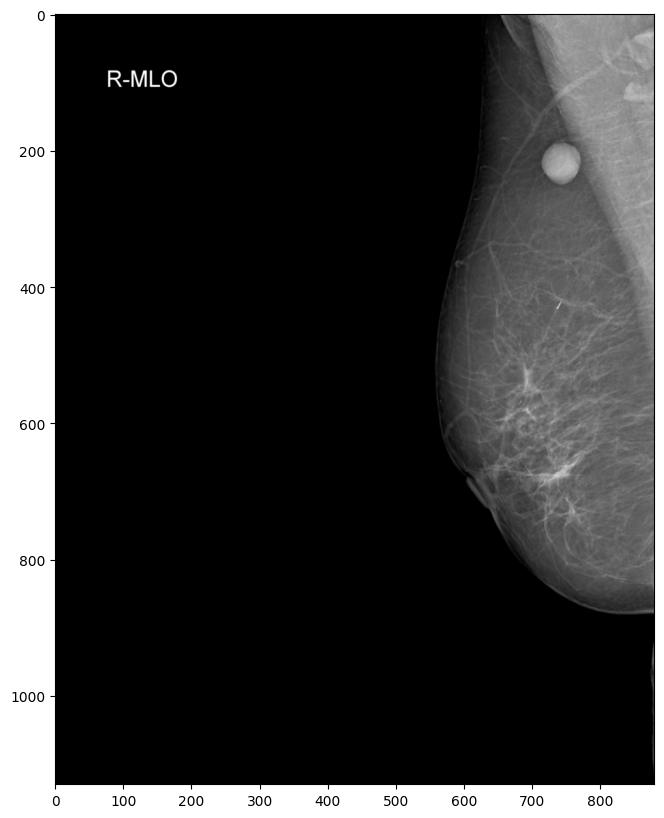

{'boxes': array([], shape=(0, 4), dtype=float32),
 'labels': array([], dtype=float32),
 'scores': array([], dtype=float32),
 'birads': array([[0.14884758, 0.14884758, 0.14884758, 0.14884758, 0.40460968]],
       dtype=float32),
 'density': array([[0.1748777 , 0.1748777 , 0.1748777 , 0.47536686]], dtype=float32)}

In [ ]:
inferencer.predict(path,visualize=True)

In [ ]:
detections,birads,densities = model(img)

In [ ]:
detections

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [ ]:
densities,birads

(tensor([[0.2655, 0.2432, 0.2360, 0.2553]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor([[0.2032, 0.1743, 0.2122, 0.2327, 0.1776]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>))